In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# run params
SECTION = 'paint'
RUN_ID = '0001'
DATA_NAME = 'monet2photo'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' # 'build' # 

TRAIN_DATA_FOLDER = './data/monet2photo/trainA/*.jpg'

TEST_DATA_FOLDER = './data/monet2photo/testA/*.jpg'

image_save_folder = os.path.join(RUN_FOLDER, 'images')
model_save_path =  os.path.join(RUN_FOLDER, 'weights/cycle_gan_monet2photo.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
BATCH_SIZE = 1
IMAGE_SIZE = 128

In [4]:
transform = transforms.Compose([   
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])


class SimpleDataset(Dataset):
    def __init__(self, filenames, transform=None, mode='train'):
        self.A_filenames = glob(filenames)
        self.B_filenames = glob(filenames.replace('trainA', 'trainB')) if mode=='train' else glob(filenames.replace('testA', 'testB'))
        
        self.transform = transform

    def __len__(self):
        return len(self.A_filenames)

    def __getitem__(self, idx):
        img1 = Image.open(self.A_filenames[idx])
        img2 = Image.open(self.B_filenames[idx])

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return [img1, img2]

In [5]:
train_dataset = SimpleDataset(TRAIN_DATA_FOLDER, transform)
train_dataloader = DataLoader(train_dataset, BATCH_SIZE,drop_last = True, shuffle=True)

test_dataset = SimpleDataset(TEST_DATA_FOLDER, transform, mode='test')
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, drop_last = True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
a,b= next(iter(DataLoader(SimpleDataset(TRAIN_DATA_FOLDER, transform), BATCH_SIZE,drop_last = True, shuffle=True)))

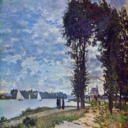

In [7]:
transforms.ToPILImage()(a.squeeze())

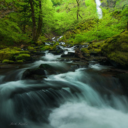

In [8]:
transforms.ToPILImage()(b.squeeze())

In [9]:
class GeneratorUNet(nn.Module):
    def __init__(self, gen_n_filters):
        super().__init__()
        self.gen_n_filters = gen_n_filters

        self.down1 = nn.Sequential(
            nn.Conv2d(3, self.gen_n_filters, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters, affine=True),
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(self.gen_n_filters, self.gen_n_filters*2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters*2, affine=True),
            nn.ReLU()
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(self.gen_n_filters*2, self.gen_n_filters*4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters*4, affine=True),
            nn.ReLU()
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(self.gen_n_filters*4, self.gen_n_filters*8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters*8, affine=True),
            nn.ReLU()
        )

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(self.gen_n_filters*8, self.gen_n_filters*4, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters*4, affine=True),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(self.gen_n_filters*4*2, self.gen_n_filters*2, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters*2, affine=True),
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(self.gen_n_filters*2*2, self.gen_n_filters, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters, affine=True),
            nn.ReLU()
        )
        
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(self.gen_n_filters*2, 3, kernel_size=3, stride=1, padding=1),
        )
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        u1 = self.up1(d4)
        u2 = self.up2(torch.cat((u1, d3), dim=1))
        u3 = self.up3(torch.cat((u2, d2), dim=1))
        output_img = self.up4(torch.cat((u3, d1), dim=1))
        return output_img

In [10]:
class Discriminator(nn.Module):
    def __init__(self, gen_n_filters):
        super().__init__()
        self.gen_n_filters = gen_n_filters
        
        
        self.down1 = nn.Sequential(
            nn.Conv2d(3, self.gen_n_filters, kernel_size=4, stride=2, padding=1),
            nn.ReLU(0.2)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(self.gen_n_filters, self.gen_n_filters*2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters*2, affine=True),
            nn.ReLU(0.2)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(self.gen_n_filters*2, self.gen_n_filters*4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.gen_n_filters*4, affine=True),
            nn.ReLU(0.2)
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(self.gen_n_filters*4, self.gen_n_filters*8, kernel_size=4, stride=1, padding=2),
            nn.InstanceNorm2d(self.gen_n_filters*8, affine=True),
            nn.ReLU(0.2),
            nn.Conv2d(self.gen_n_filters*8, 1, 4, 1, 1)
        )
    
    def forward(self, x):
        
        x = self.down1(x)        

        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        return x

In [11]:
g_AB = GeneratorUNet(32).to(device)
g_BA = GeneratorUNet(32).to(device)
d_A = Discriminator(32).to(device)
d_B = Discriminator(32).to(device)

In [12]:
d_A_optimizer = optim.Adam(d_A.parameters(), lr=0.5, betas=(0.5, 0.999))
d_B_optimizer = optim.Adam(d_B.parameters(), lr=0.5, betas=(0.5, 0.999))


import itertools
g_optimizer = optim.Adam(itertools.chain(g_AB.parameters(), g_AB.parameters()), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.MSELoss()

C:\Users\ggh5454\.conda\envs\pytorch_env1\lib\site-packages\torch\optim\adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [13]:
import numpy as np
import torchvision.utils as vutils

In [ ]:
lambda_validation = 1
lambda_reconstr = 10
lambda_id = 1
real_label = 1.
fake_label = 0.
real_tensor = torch.ones(BATCH_SIZE, 1, 16, 16).to(device)
fake_tensor = torch.zeros(BATCH_SIZE, 1, 16, 16).to(device)
epochs = 200
D_losses = []
G_losses = []
validation_losses = []
reconstr_losses = []
id_losses = []

for epoch in range(epochs):
    epoch_validation_loss = 0.0
    epoch_reconstr_loss = 0.0
    epoch_id_loss = 0.0
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    for (real_A, real_B) in train_dataloader:
        # Move data to device

        real_A = real_A.to(device)
        real_B = real_B.to(device)

        fake_B = g_AB(real_A)
        fake_A = g_BA(real_B)


        d_A_optimizer.zero_grad()
        d_A_real_output = d_A(real_A)
        d_A_real_loss = criterion(d_A_real_output, real_tensor)
        valid_A = d_A(fake_A)
        d_A_fake_loss = criterion(valid_A, fake_tensor)
        d_A_loss = 0.5 * ( d_A_real_loss+ d_A_fake_loss)
        d_A_loss.backward()
        d_A_optimizer.step()

        d_B_optimizer.zero_grad()
        d_B_real_output = d_B(real_B)
        d_B_real_loss = criterion(d_B_real_output, real_tensor)
        valid_B = d_B(fake_B)
        d_B_fake_loss = criterion(valid_B, fake_tensor)
        d_B_loss = 0.5 * ( d_B_real_loss+ d_B_fake_loss)
        d_B_loss.backward()
        d_B_optimizer.step()
        d_loss = 0.5 * (d_A_loss + d_B_loss)


        # Generator
        for p in d_A.parameters():
            p.requires_grad = False
        for p in d_B.parameters():
            p.requires_grad = False


        g_optimizer.zero_grad()

        fake_B = g_AB(real_A)
        fake_A = g_BA(real_B)
        reconstr_A = g_BA(fake_B)
        reconstr_B = g_AB(fake_A)
        id_A = g_BA(real_A)
        id_B = g_AB(real_B)
        valid_A = d_A(fake_A)
        valid_B = d_B(fake_B)

        validation_loss = criterion(real_tensor, valid_A) +\
                          criterion(real_tensor, valid_B)
        reconstr_loss = F.l1_loss(real_A, reconstr_A) +\
                        F.l1_loss(real_B, reconstr_B)
        id_loss = F.l1_loss(real_A, id_A) +\
                  F.l1_loss(real_B, id_B)
        g_loss = lambda_validation * validation_loss + lambda_reconstr * reconstr_loss + lambda_id * id_loss

        g_loss.backward()
        g_optimizer.step()

        for p in d_A.parameters():
            p.requires_grad = True
        for p in d_B.parameters():
            p.requires_grad = True
        epoch_D_loss += d_loss.item() * real_A.size(0)
        epoch_G_loss += g_loss.item() * real_A.size(0)
        epoch_validation_loss += validation_loss.item() * real_A.size(0)
        epoch_reconstr_loss += reconstr_loss.item() * real_A.size(0)
        epoch_id_loss += id_loss.item() * real_A.size(0)
    epoch_D_loss /= len(train_dataloader)
    epoch_G_loss /= len(train_dataloader)
    epoch_validation_loss /= len(train_dataloader)
    epoch_reconstr_loss /= len(train_dataloader)
    epoch_id_loss /= len(train_dataloader)
    
    D_losses.append(epoch_D_loss)
    G_losses.append(epoch_G_loss)
    validation_losses.append(epoch_validation_loss)
    reconstr_losses.append(epoch_reconstr_loss)
    id_losses.append(epoch_id_loss)
    print("[Epoch %d/%d] [D loss: %f] [G loss: %05f, adv: %05f, recon: %05f, id: %05f]"\
        % (epoch, epochs,
           epoch_D_loss, 
           epoch_G_loss,
           epoch_validation_loss,
           epoch_reconstr_loss,
           epoch_id_loss))
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            test_A_images, test_B_images = next(iter(test_dataloader))
            test_A_image = test_A_images[0].to(device).reshape(1, 3, 128, 128)
            test_B_image = test_B_images[1].to(device).reshape(1, 3, 128, 128)
            fake_B = g_AB(test_A_image)
            fake_A = g_BA(test_B_image)
            reconstr_A = g_BA(fake_B)
            reconstr_B = g_AB(fake_A)
            id_A = g_BA(test_A_image)
            id_B = g_AB(test_B_image)

        result_imgs = torch.cat([test_A_image, fake_B, reconstr_A, id_A,
                                 test_B_image, fake_A, reconstr_B, id_B], dim=0).detach().cpu()
        plt.figure(figsize=(20, 12))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(result_imgs,
                                                 nrow=4,
                                                 padding=2,
                                                 normalize=True), (1, 2, 0)))
        plt.savefig(os.path.join(image_save_folder, f'result_img_e_{epoch + 1}.png'))

        torch.save({'d_A': d_A.state_dict(),
                    'd_B': d_B.state_dict(),
                    'g_AB': g_AB.state_dict(),
                    'g_BA': g_BA.state_dict()},
                   model_save_path)



In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot([x for x in D_losses], color='black', linewidth=1)
plt.plot([x for x in validation_losses], color='green', linewidth=1)
plt.plot([x for x in reconstr_losses], color='blue', linewidth=1)
plt.plot([x for x in id_losses], color='red', linewidth=1)

plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.savefig(os.path.join(image_save_folder, 'loss_graph.png'))

In [ ]:
idx = 1
for inputs_A, inputs_B in test_dataloader:
    inputs_A = inputs_A.to(device)
    inputs_B = inputs_B.to(device)

    fake_B = g_AB(inputs_A)
    fake_A = g_BA(inputs_B)
    reconstr_A = g_BA(fake_B)
    reconstr_B = g_AB(fake_A)
    id_A = g_BA(inputs_A)
    id_B = g_AB(inputs_B)
    valid_A = d_A(fake_A)
    valid_B = d_B(fake_B)

    result_imgs = torch.cat([inputs_A, fake_B, reconstr_A, id_A,
                            inputs_B, fake_A, reconstr_B, id_B], dim=0).detach().cpu()
    plt.figure(figsize=(20, 12))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(result_imgs,
                                                nrow=4,
                                                padding=2,
                                                normalize=True), (1, 2, 0)))
    plt.savefig(os.path.join(image_save_folder, f'test_input_result_img_{idx}.png'))
    idx += 1
    
    if idx % 10 == 0:
        break